In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
siglist = [ (700,300,), (1000,450), (1200,500) ]

In [4]:
modules = dict(
  p4_points=fc.eightb.preselection.ranked_quadh,
  dr_points=fc.eightb.preselection.ranked_quadh_m10
)

use_gen = dict(
  p4_points=False
)

In [5]:
get_fn = lambda module, mx, my: getattr(module, f"NMSSM_XYY_YToHH_8b_MX_{mx}_MY_{my}")

signals = [
  ObjIter([Tree( get_fn(module, mx, my), use_gen=use_gen.get(key, True)) for mx, my in siglist])
  for key, module in modules.items()
]

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


In [6]:
def set_color(args): 
  t, c = args
  t.color = c
sigcol = ObjIter(['tab:blue','tab:green'])
for signal in signals:
  signal.zip(sigcol).apply(set_color)


In [7]:
bkgs = [
  ObjIter([])
  for module in modules.values()
]

In [8]:
varinfo.quadh_score = dict(bins=(0,0.7,30))
varinfo.higgs_m = dict(bins=(0,300,30))
varinfo.nfound_paired_h = dict(xlabel='N Correctly Paired H', bins=None)

In [9]:
use_bkg = any((any(bkg) for bkg in bkgs))
def compare_modules(var, bkg=use_bkg, **kwargs):
  n = len(signals[0])+1 if bkg else len(signals[0])
  fig, axs = study.get_figax(n, dim=(-1,n))
  label = list(modules.keys())

  for i, samples in enumerate(zip(*signals)):
    study.quick(
      list(samples), legend=True,
      label=label,
      h_linestyle=[':','--','-'],
      varlist=[var],
      text=(0.0,1.0, samples[0].sample),
      text_style=dict(ha='left',va='bottom'),
      figax=(fig,axs.flat[i]),
      **kwargs,
    )

  if not bkg: return

  study.quick_region(
    *bkgs, legend=True,
    h_color=['grey']*3,
    label=label,
    h_linestyle=[':','--','-'],
    varlist=[var],
    text=(0.0,1.0,'MC-Bkg'),
    text_style=dict(ha='left',va='bottom'),
    figax=(fig,axs.flat[-1]),
    **kwargs,
  )

In [10]:
def compare_samples(var, bkg=use_bkg, **kwargs):
  fig, axs = study.get_figax(2, dim=(-1,2))

  samples = signals

  if bkg:
    samples = [ sample+bkg for sample, bkg in zip(samples, bkgs)]
  label=list(modules.keys())
  h_linestyle=[':','--','-']


  for i, sample in enumerate(samples):
    study.quick(
      sample, legend=True, stacked=True,
      varlist=[var],
      h_linestyle=[h_linestyle[i]]*sample.is_signal.npy.sum(),
      text=(0.0,1.0, label[i]),
      text_style=dict(ha='left',va='bottom'),
      efficiency=True,
      figax=(fig,axs.flat[i]),
      **kwargs,
    )

100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


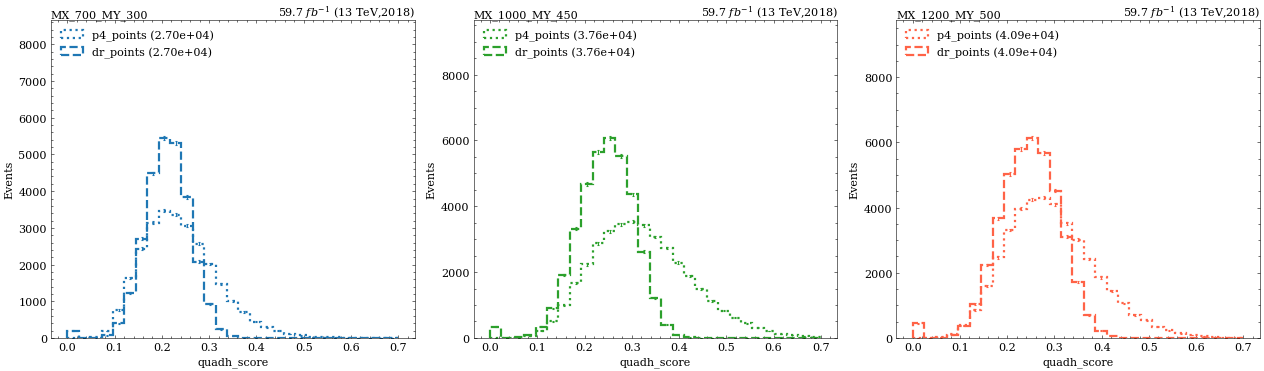

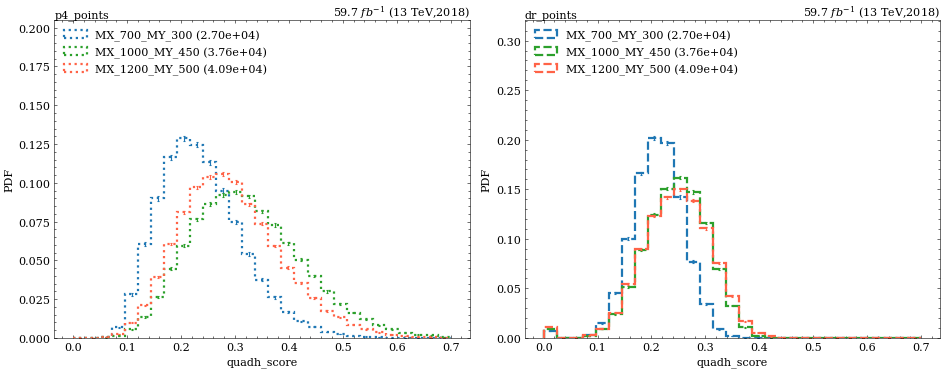

In [11]:
compare_modules('quadh_score')
compare_samples('quadh_score')

In [32]:
for it in signals+bkgs:
  it.apply(lambda t:build_collection(t, 'H\dY\d','higgs',ptordered=True))

100%|██████████| 1/1 [00:00<00:00, 13.38it/s]


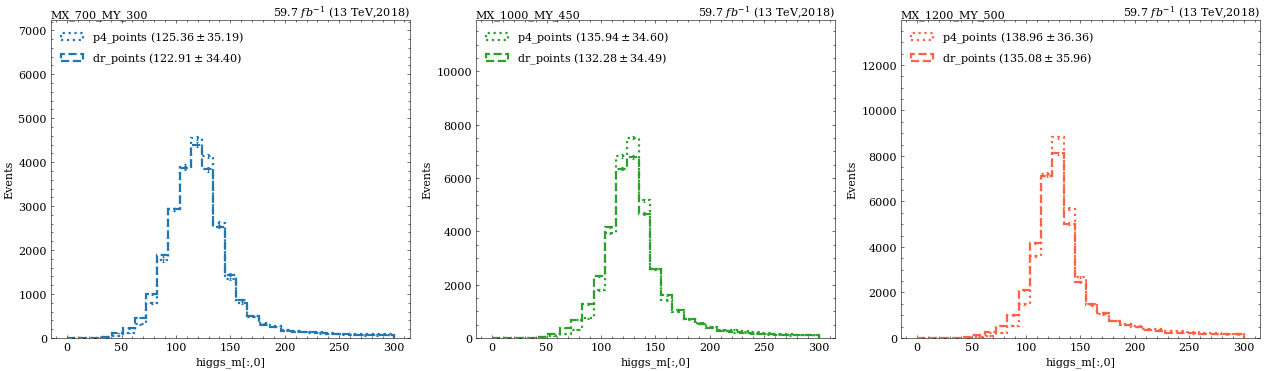

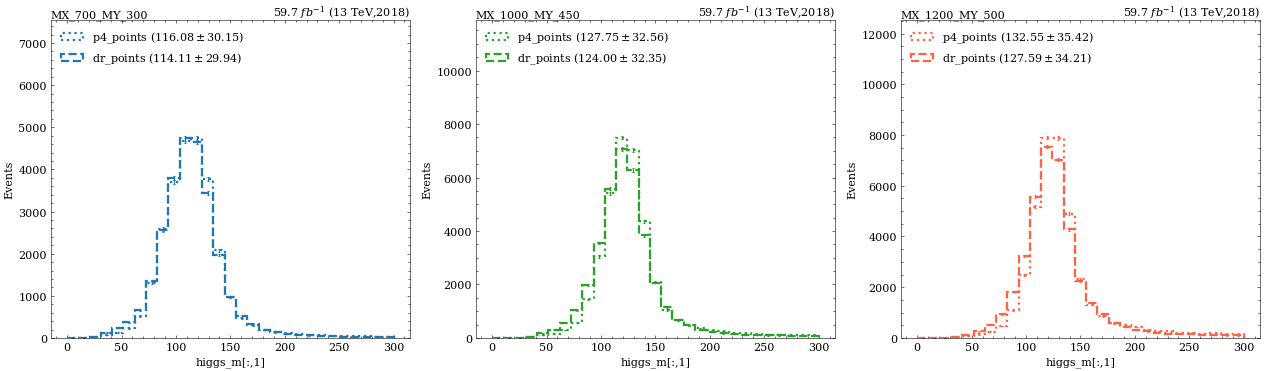

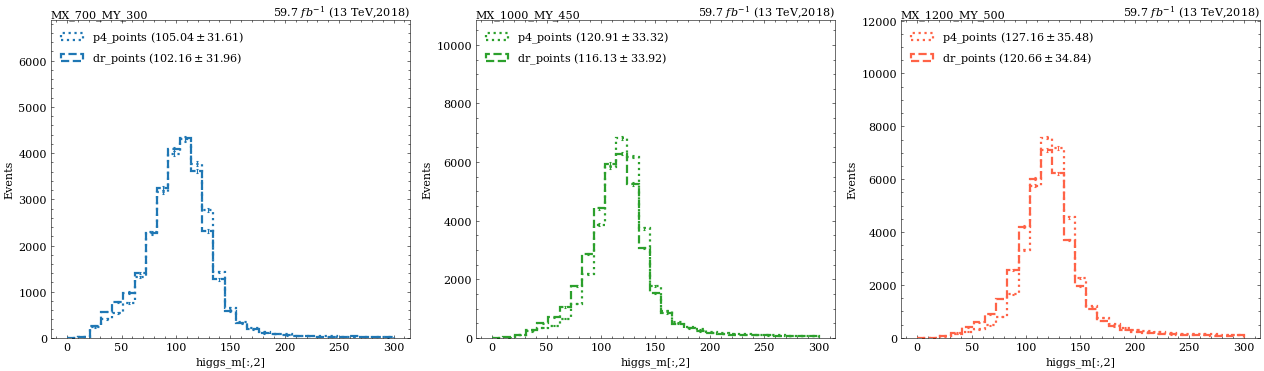

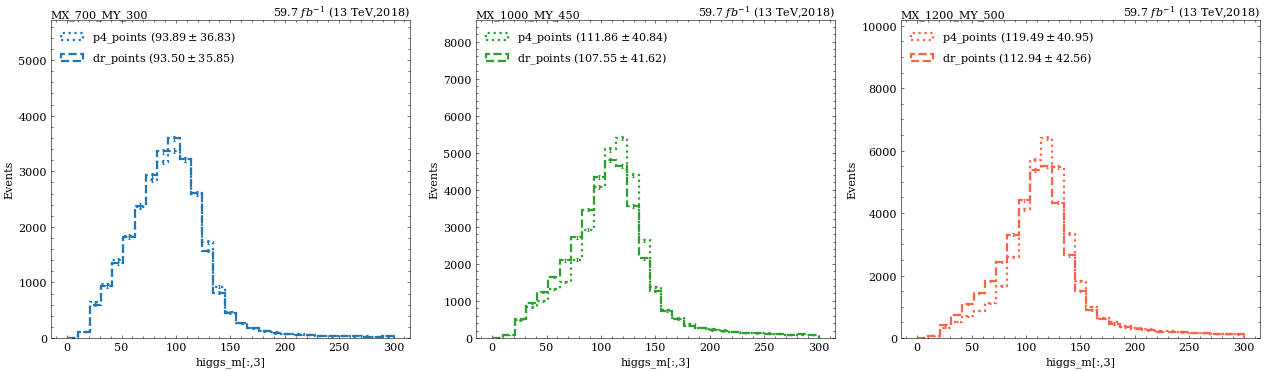

In [33]:
for i in range(4):
  compare_modules(f'higgs_m[:,{i}]', h_label_stat='${stats.mean:0.2f}\pm{stats.stdv:0.2f}$')

100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


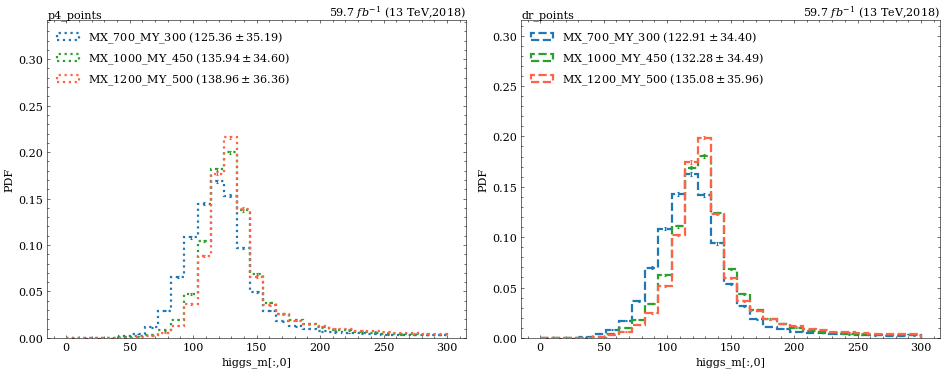

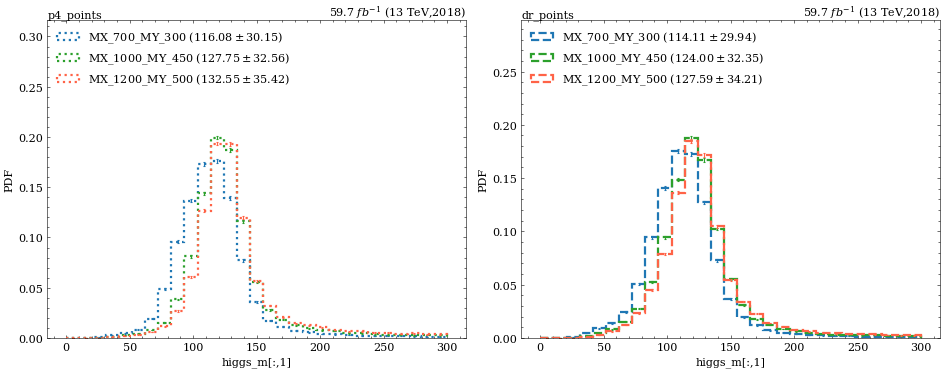

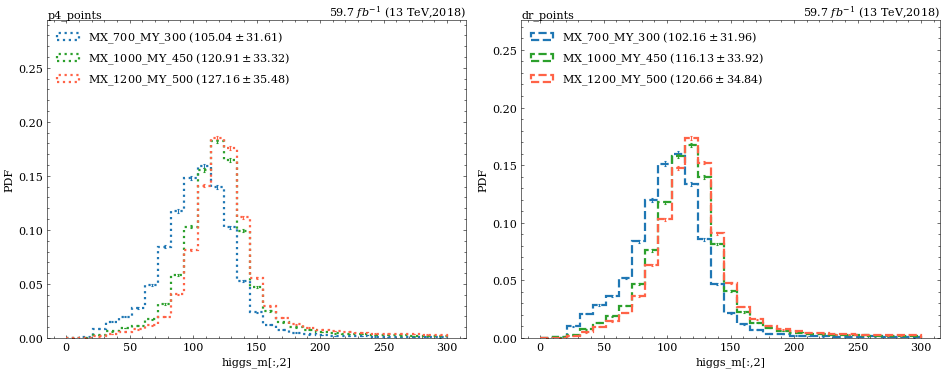

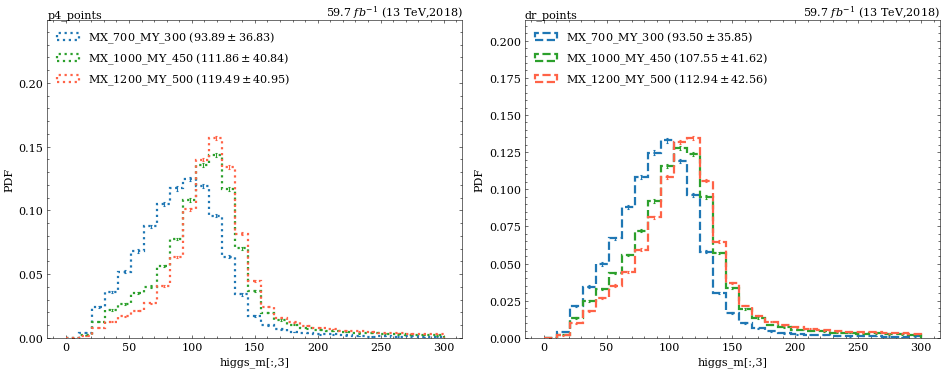

In [34]:
for i in range(4):
  compare_samples(f'higgs_m[:,{i}]', h_label_stat='${stats.mean:0.2f}\pm{stats.stdv:0.2f}$')

100%|██████████| 1/1 [00:00<00:00, 16.10it/s]


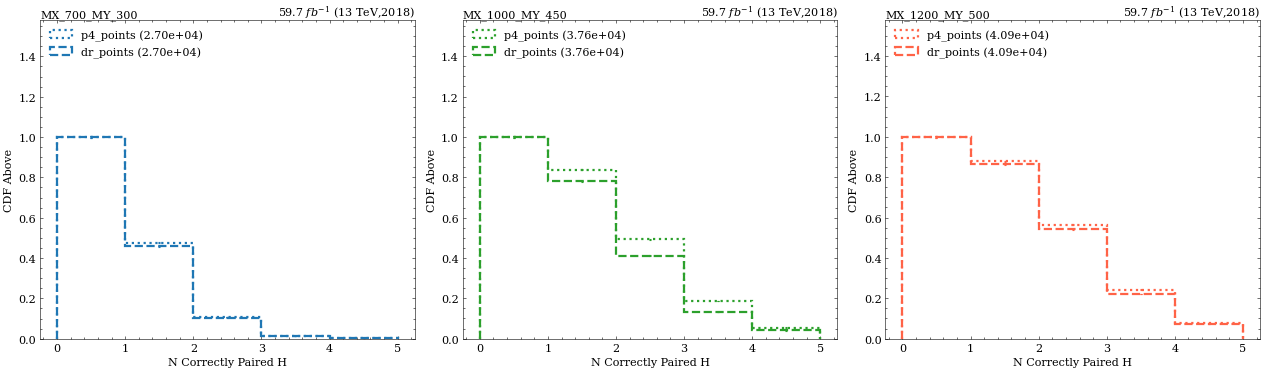

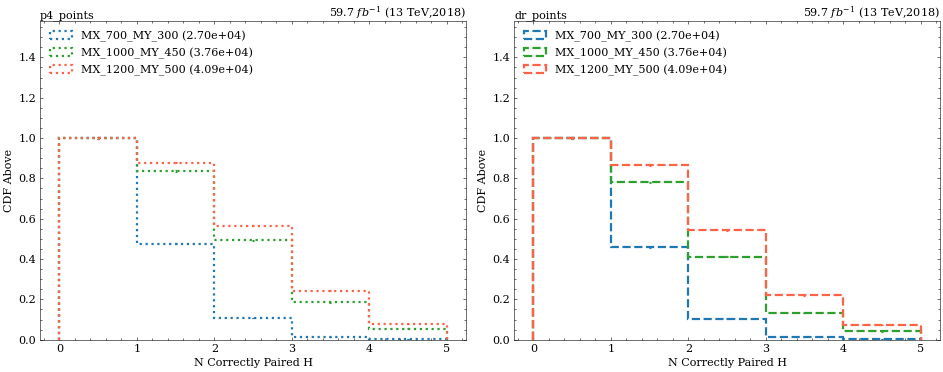

In [35]:
compare_modules('nfound_paired_h', bkg=False, cumulative=-1)
compare_samples('nfound_paired_h', bkg=False, cumulative=-1)


In [36]:
def true_higgs(t, i):
  b1 = (t.higgs_b1_genHflag[:,i]+1)//2
  b2 = (t.higgs_b2_genHflag[:,i]+1)//2
  return (b1 == b2)&(b1 != 0)

100%|██████████| 1/1 [00:00<00:00, 12.89it/s]


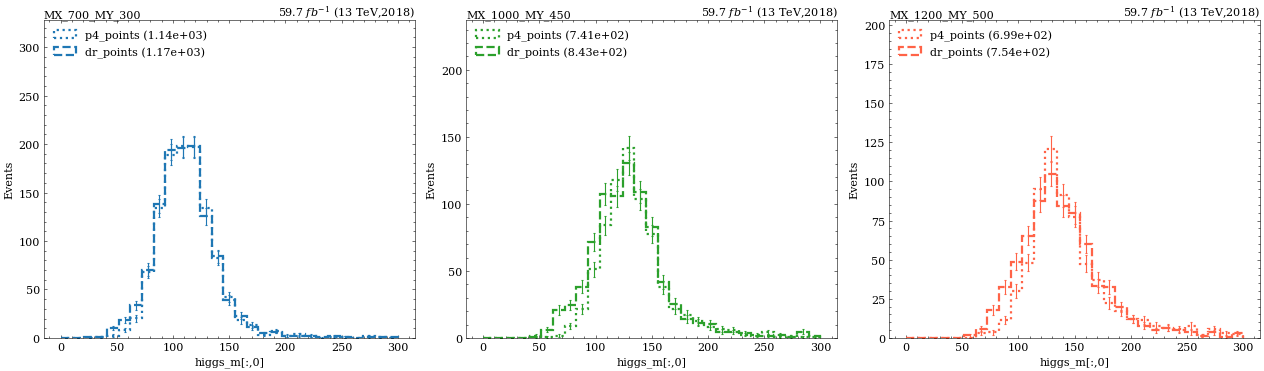

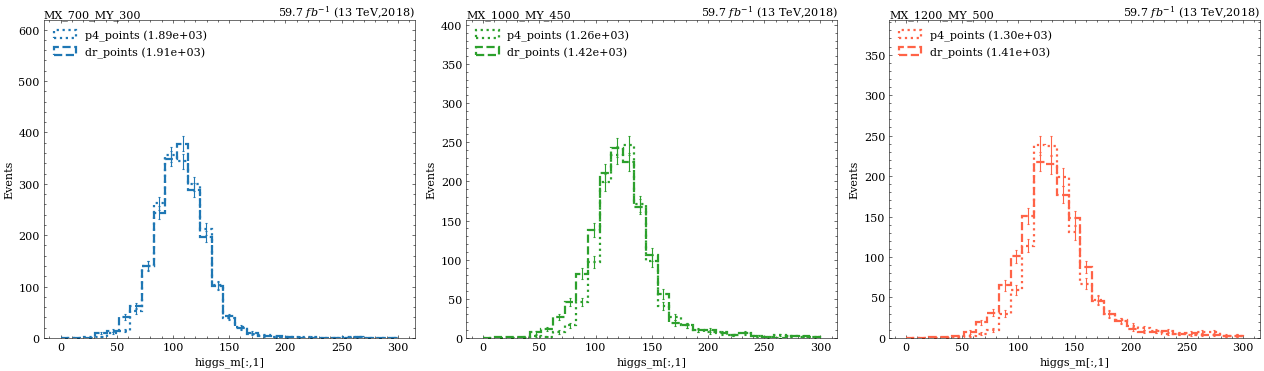

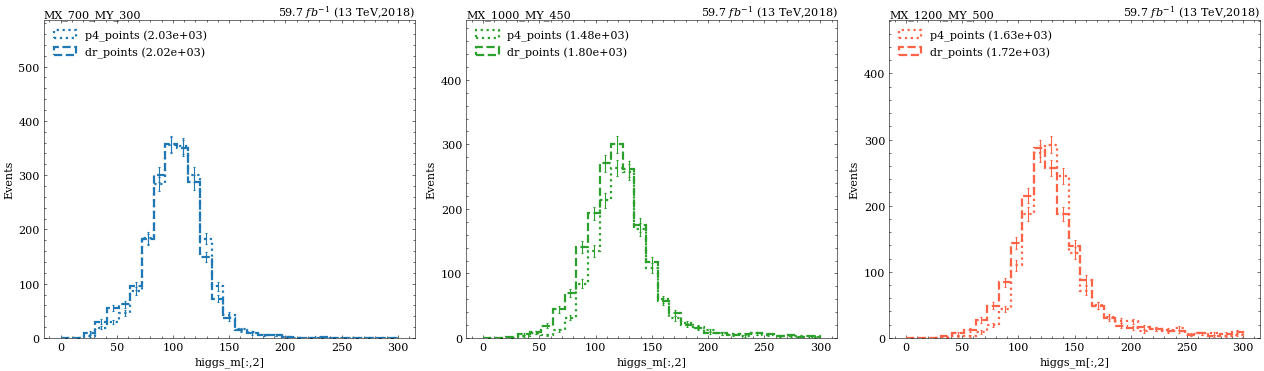

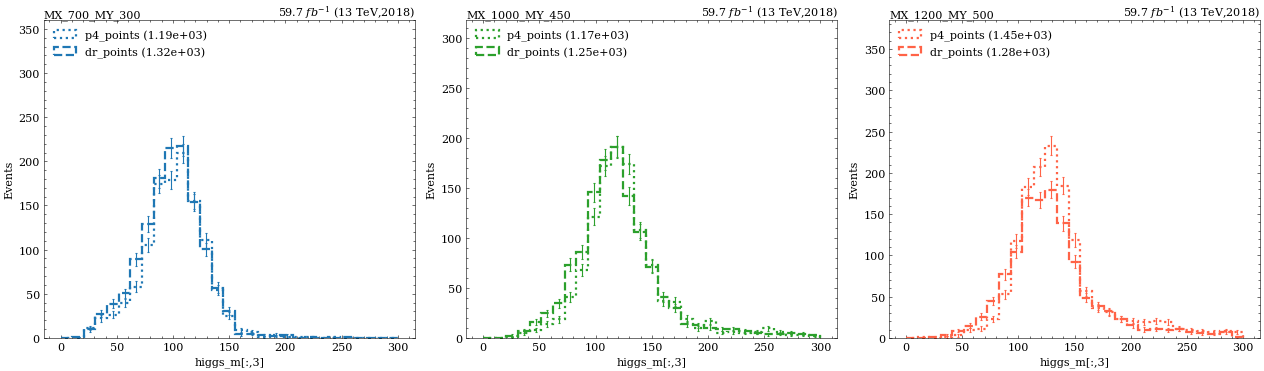

In [37]:
for i in range(4):
  compare_modules(f'higgs_m[:,{i}]', masks=lambda t:true_higgs(t, i), bkg=False)